In [52]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from stan_sirvc_layer import run_layer, get_features
import matplotlib.dates as mdates

In [53]:
#GenerateTrainingData().download_jhu_data('2020-08-01', '2020-12-01')
start_date = '2021-01-01'
end_date = '2021-05-31'

In [54]:
# data processing
raw_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date)
raw_data = raw_data.loc[mask]

countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
countries.remove("European Union")
countries.remove("Europe")
countries.remove("Africa")
countries.remove("Asia")
countries.remove("North America")
countries.remove("Oceania")
countries.remove("South America")
countries.remove("World")
countries.remove("Tajikistan")
continents = ["Europe", "Africa", "Asia", "North America", "South America", "Oceania"]
world = ["World"]

country_mask = raw_data['location'].isin(countries)
continent_mask = raw_data['location'].isin(continents)
world_mask = raw_data['location'].isin(world)

country_raw_data = raw_data.loc[country_mask]
continent_raw_data = raw_data.loc[continent_mask]
world_raw_data = raw_data.loc[world_mask]

print(len(country_raw_data['location'].unique()))   # 163
print(len(continent_raw_data['location'].unique())) # 6
print(len(world_raw_data['location'].unique()))     # 1

163
6
1


In [55]:
# layer 1, 2, 3
test_window = 29
history_window=14 # days of information
pred_window=14 # predicts future # of days
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)

#g, all_features, active_cases, static_feat, norms = get_features(country_raw_data, start_date, end_date, countries)


In [56]:

_, world_features, world_active_cases, world_static_feat, world_norms = get_features(world_raw_data, start_date, end_date, world, edges=False)

done


In [57]:
country_pred_prev = np.array(pickle.load(open('results/trained_countries_pred_dI_prev', 'rb'))).squeeze(2)
country_pred_test = np.array(pickle.load(open('results/trained_countries_pred_dI', 'rb'))).squeeze(2)

In [58]:
# get true_dI for each continent
true_dI_train = world_features[0][5] # 0=train, 5=yI; locations, timesteps, values
true_dI_val = world_features[1][5]

# target for train and test
true_dI_prev = np.concatenate((true_dI_train, true_dI_val), axis=1)
true_dI_test = world_features[2][5]

In [59]:
class MLP(nn.Module):
    def __init__(self, n_countries, pred_window):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_countries*pred_window, 64),
            nn.ReLU(),
            nn.Linear(64, pred_window)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [60]:
# normalize by continent norm
input_country_pred_prev = (country_pred_prev - world_norms[0][0]) / world_norms[1][0]
input_country_pred_test = (country_pred_test - world_norms[0][0]) / world_norms[1][0]

print(input_country_pred_test.shape)

x_train = input_country_pred_prev.transpose(1, 0, 2) # swap locs with timesteps
x_test = input_country_pred_test.transpose(1, 0, 2)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

print(x_train.shape)
print(x_test.shape)

y_train = true_dI_prev[0]
y_test = true_dI_test[0]

print(y_train.shape)
print(y_test.shape)


(163, 1, 14)
(19, 2282)
(1, 2282)
(19, 14)
(1, 14)


In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(x_train, dtype=torch.float).to(device)
x_test = torch.tensor(x_test, dtype=torch.float).to(device)

y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

In [62]:
model = MLP(len(countries), pred_window).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2282, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=14, bias=True)
  )
)


In [63]:
for epoch in range(2000):
    model.train()

    optimizer.zero_grad()
    train_pred = model(x_train)
    loss = loss_fn(train_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))

Epoch 0: train loss: 0.613050103187561
Epoch 100: train loss: 0.24186336994171143
Epoch 200: train loss: 0.10087141394615173
Epoch 300: train loss: 0.08710150420665741
Epoch 400: train loss: 0.0732966959476471
Epoch 500: train loss: 0.06665835529565811
Epoch 600: train loss: 0.0629306510090828
Epoch 700: train loss: 0.06240549311041832
Epoch 800: train loss: 0.05820969492197037
Epoch 900: train loss: 0.05656491219997406
Epoch 1000: train loss: 0.05492010712623596
Epoch 1100: train loss: 0.053395483642816544
Epoch 1200: train loss: 0.05362538993358612
Epoch 1300: train loss: 0.05112830176949501
Epoch 1400: train loss: 0.04957938566803932
Epoch 1500: train loss: 0.049003615975379944
Epoch 1600: train loss: 0.04761912673711777
Epoch 1700: train loss: 0.045940522104501724
Epoch 1800: train loss: 0.0449959896504879
Epoch 1900: train loss: 0.043670184910297394


In [64]:
# file_name = './all_models/mlp_' + continent
# checkpoint = torch.load(file_name)
# model.load_state_dict(checkpoint['state'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# model.eval()

test_pred = model(x_test)
train_pred = model(x_train)
# Cumulate predicted dI

pred_I = (test_pred.detach().cpu().numpy() * world_norms[1][0]) + world_norms[0][0]
pred_I_prev = (train_pred.detach().cpu().numpy() * world_norms[1][0]) + world_norms[0][0]
# pickle.dump(pred_I, open(f"./results/trained_{continent}_pred_dI", 'wb'), 2)
# pickle.dump(pred_I_prev, open(f"./results/trained_{continent}_pred_dI_prev", 'wb'), 2)
pred_I = np.cumsum(pred_I)

test_I = world_features[2][1]

pred_I = pred_I + test_I[0]
print(pred_I)

pred_I = np.array(pred_I)

[10165425. 10124678. 10018724. 10008360. 10016949.  9962022.  9928504.
  9958480.  9924325.  9929514.  9949543.  9937179.  9940094.  9970669.]


In [65]:
I_true = world_active_cases[0][-test_window:]
I_true = I_true[history_window:history_window+pred_window]
print(I_true)

[10058856.  9873921.  9704407.  9113707.  8906597.  8698972.  8533923.
  8367378.  8160793.  7969293.  7799285.  7581473.  7434742.  7277611.]


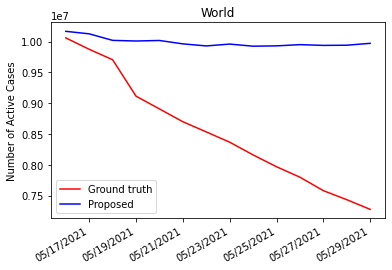

In [66]:
import matplotlib.dates as mdates
dates = [test_start_date + pd.DateOffset(days=i+history_window) for i in range(pred_window)]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.plot(dates, I_true, c='r', label='Ground truth')
plt.plot(dates, pred_I, c='b', label='Proposed')
# stan_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_new", "rb"))
# stan_sirv_res = pickle.load(open(f"stan_results/{loc_name}_stan_results_sirv", "rb"))
# plt.plot(dates, stan_res[-1, :], c='g', label="STAN (SIRV)")
# plt.plot(dates, sir_I[-1, :], c='purple', label="SIRVIC")
plt.gcf().autofmt_xdate()
plt.legend()
plt.ylabel("Number of Active Cases")
plt.title("World")
plt.show()

In [67]:
prop_mse = ((pred_I - I_true)**2).mean()
print(f"Proposed: {prop_mse}")

Proposed: 2780921110157.857


In [68]:
for pred in pred_I:
    print(pred)

10165425.0
10124678.0
10018724.0
10008360.0
10016949.0
9962022.0
9928504.0
9958480.0
9924325.0
9929514.0
9949543.0
9937179.0
9940094.0
9970669.0
